svm threshold tuning


✅ Calibrated SVM model loaded
✅ Unseen dataset created: (100, 2)

📊 THRESHOLD TUNING TABLE


,Threshold,Precision,Recall,F1 Score,False Positives,False Negatives,Business Cost
0,0.10,0.729,0.70,0.714,13,15,1760
1,0.15,0.729,0.70,0.714,13,15,1760
2,0.20,0.729,0.70,0.714,13,15,1760
3,0.25,0.729,0.70,0.714,13,15,1760
4,0.30,0.729,0.70,0.714,13,15,1760
5,0.35,0.729,0.70,0.714,13,15,1760
6,0.40,0.729,0.70,0.714,13,15,1760
7,0.45,0.729,0.70,0.714,13,15,1760
8,0.50,0.729,0.70,0.714,13,15,1760
9,0.55,0.729,0.70,0.714,13,15,1760


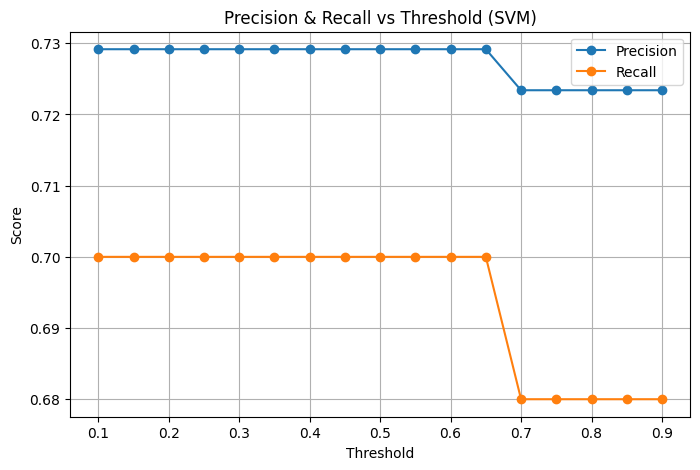

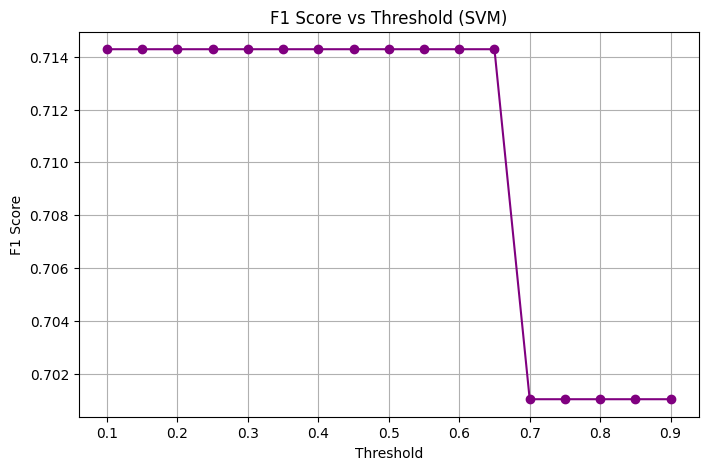

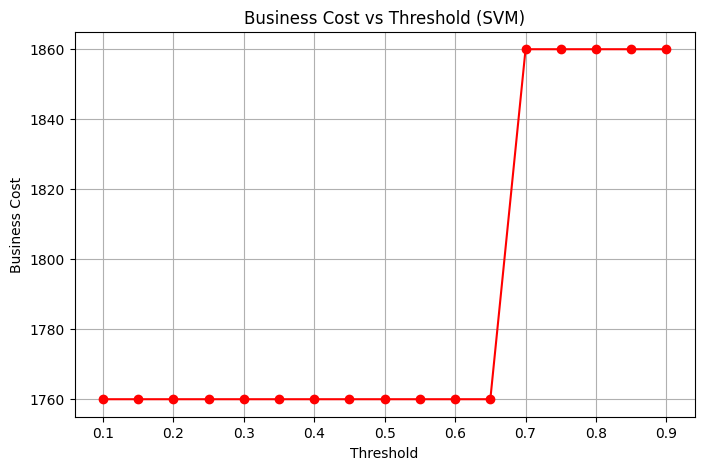


✅ OPTIMAL THRESHOLD SELECTED
Threshold             0.100000
Precision             0.729167
Recall                0.700000
F1 Score              0.714286
False Positives      13.000000
False Negatives      15.000000
Business Cost      1760.000000
Name: 0, dtype: float64

📌 FINAL THRESHOLD TUNING SUMMARY
{'model': 'Calibrated Linear SVM', 'optimal_threshold': 0.1, 'precision': np.float64(0.7292), 'recall': np.float64(0.7), 'f1_score': np.float64(0.7143), 'false_positives': 13, 'false_negatives': 15, 'business_cost': 1760, 'evaluated_on': '2026-01-29T14:45:53.466997+00:00'}


In [5]:
import joblib
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, UTC
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)

# ======================================================
# PATHS
# ======================================================
ARTIFACT_DIR = r"C:\medveraxbecustom\model_artifacts"

MODEL_PATH = f"{ARTIFACT_DIR}\\linear_svm_calibrated_model.pkl"
VECTORIZER_PATH = f"{ARTIFACT_DIR}\\tfidf_vectorizer.pkl"

# ======================================================
# LOAD MODEL & VECTORIZER
# ======================================================
model = joblib.load(MODEL_PATH)
vectorizer = joblib.load(VECTORIZER_PATH)

print("✅ Calibrated SVM model loaded")

# ======================================================
# CREATE UNSEEN DATA (INSIDE CODE)
# ======================================================
random.seed(42)

diseases = [
    "diabetes", "cancer", "hypertension",
    "asthma", "arthritis", "covid"
]

reliable_templates = [
    "Clinical guidelines recommend medical supervision for {d}",
    "Doctors advise evidence based treatment for {d}",
    "Treatment of {d} depends on diagnosis and severity",
    "Medical professionals manage {d} using proven therapies",
]

misinfo_templates = [
    "{d} can be cured permanently without doctors",
    "Natural remedies guarantee cure for {d}",
    "Doctors hide the real cure for {d}",
    "{d} does not need any medical treatment",
]

texts, labels = [], []

for _ in range(50):
    texts.append(random.choice(reliable_templates).format(d=random.choice(diseases)))
    labels.append(0)

for _ in range(50):
    texts.append(random.choice(misinfo_templates).format(d=random.choice(diseases)))
    labels.append(1)

df_unseen = pd.DataFrame({"text": texts, "label": labels})

print("✅ Unseen dataset created:", df_unseen.shape)

# ======================================================
# VECTORIZE
# ======================================================
X_unseen = vectorizer.transform(df_unseen["text"])
y_true = df_unseen["label"].values

# ======================================================
# GET PROBABILITIES
# ======================================================
y_prob = model.predict_proba(X_unseen)[:, 1]

# ======================================================
# THRESHOLD TUNING
# ======================================================
thresholds = np.arange(0.1, 0.91, 0.05)

rows = []

for t in thresholds:
    y_pred = (y_prob >= t).astype(int)

    p = precision_score(y_true, y_pred)
    r = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Business cost assumption
    # False Negative = 100 (dangerous misinformation missed)
    # False Positive = 20  (safe info flagged)
    cost = fn * 100 + fp * 20

    rows.append({
        "Threshold": t,
        "Precision": p,
        "Recall": r,
        "F1 Score": f1,
        "False Positives": fp,
        "False Negatives": fn,
        "Business Cost": cost
    })

df_threshold = pd.DataFrame(rows)

# ======================================================
# DISPLAY TABLE
# ======================================================
print("\n📊 THRESHOLD TUNING TABLE")
display(df_threshold.round(3) if "display" in globals() else df_threshold.round(3))

# ======================================================
# VISUAL 1 — Threshold vs Precision / Recall
# ======================================================
plt.figure(figsize=(8,5))
plt.plot(df_threshold["Threshold"], df_threshold["Precision"], marker="o", label="Precision")
plt.plot(df_threshold["Threshold"], df_threshold["Recall"], marker="o", label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision & Recall vs Threshold (SVM)")
plt.legend()
plt.grid(True)
plt.show()

# ======================================================
# VISUAL 2 — Threshold vs F1
# ======================================================
plt.figure(figsize=(8,5))
plt.plot(df_threshold["Threshold"], df_threshold["F1 Score"], marker="o", color="purple")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Threshold (SVM)")
plt.grid(True)
plt.show()

# ======================================================
# VISUAL 3 — Threshold vs Business Cost
# ======================================================
plt.figure(figsize=(8,5))
plt.plot(df_threshold["Threshold"], df_threshold["Business Cost"], marker="o", color="red")
plt.xlabel("Threshold")
plt.ylabel("Business Cost")
plt.title("Business Cost vs Threshold (SVM)")
plt.grid(True)
plt.show()

# ======================================================
# SELECT OPTIMAL THRESHOLD
# ======================================================
best_row = df_threshold.loc[df_threshold["Business Cost"].idxmin()]

optimal_threshold = best_row["Threshold"]

print("\n✅ OPTIMAL THRESHOLD SELECTED")
print(best_row)

# ======================================================
# FINAL DECISION SUMMARY
# ======================================================
summary = {
    "model": "Calibrated Linear SVM",
    "optimal_threshold": float(optimal_threshold),
    "precision": round(best_row["Precision"], 4),
    "recall": round(best_row["Recall"], 4),
    "f1_score": round(best_row["F1 Score"], 4),
    "false_positives": int(best_row["False Positives"]),
    "false_negatives": int(best_row["False Negatives"]),
    "business_cost": int(best_row["Business Cost"]),
    "evaluated_on": datetime.now(UTC).isoformat()
}

print("\n📌 FINAL THRESHOLD TUNING SUMMARY")
print(summary)


lr threshold tuning


✅ Logistic Regression model loaded

📊 LR THRESHOLD TABLE
    Threshold  Precision  Recall  F1 Score  False Positives  False Negatives  \
0        0.10      0.500    1.00     0.667               50                0   
1        0.15      0.500    1.00     0.667               50                0   
2        0.20      0.500    1.00     0.667               50                0   
3        0.25      0.500    1.00     0.667               50                0   
4        0.30      0.500    1.00     0.667               50                0   
5        0.35      0.500    1.00     0.667               50                0   
6        0.40      0.500    1.00     0.667               50                0   
7        0.45      0.500    1.00     0.667               50                0   
8        0.50      0.500    1.00     0.667               50                0   
9        0.55      0.500    1.00     0.667               50                0   
10       0.60      0.500    1.00     0.667               50    

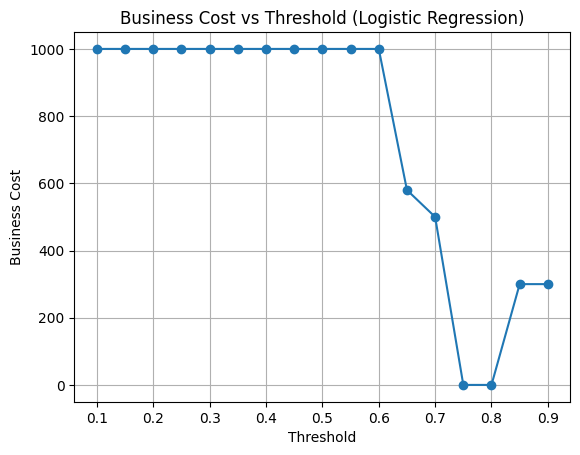


✅ OPTIMAL THRESHOLD (LR)
Threshold          0.75
Precision          1.00
Recall             1.00
F1 Score           1.00
False Positives    0.00
False Negatives    0.00
Business Cost      0.00
Name: 13, dtype: float64


In [6]:
# import joblib, random, numpy as np, pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# ARTIFACT_DIR = r"C:\medveraxbecustom\model_artifacts"
# model = joblib.load(f"{ARTIFACT_DIR}\\logistic_regression_model.pkl")
# vectorizer = joblib.load(f"{ARTIFACT_DIR}\\tfidf_vectorizer.pkl")

# # ---------- Unseen data ----------
# random.seed(42)
# diseases = ["diabetes","cancer","hypertension","asthma","arthritis","covid"]

# reliable = [
#     "Doctors recommend evidence based treatment for {d}",
#     "Clinical care is required for {d}"
# ]
# misinfo = [
#     "{d} can be cured permanently without doctors",
#     "Natural remedies guarantee cure for {d}"
# ]

# texts, labels = [], []
# for _ in range(50):
#     texts.append(random.choice(reliable).format(d=random.choice(diseases)))
#     labels.append(0)
# for _ in range(50):
#     texts.append(random.choice(misinfo).format(d=random.choice(diseases)))
#     labels.append(1)

# X = vectorizer.transform(texts)
# y = np.array(labels)

# probs = model.predict_proba(X)[:,1]
# thresholds = np.arange(0.1, 0.91, 0.05)

# rows = []
# for t in thresholds:
#     preds = (probs >= t).astype(int)
#     tn, fp, fn, tp = confusion_matrix(y, preds).ravel()
#     cost = fn*100 + fp*20
#     rows.append([t,
#                  precision_score(y, preds),
#                  recall_score(y, preds),
#                  f1_score(y, preds),
#                  fp, fn, cost])

# df_lr = pd.DataFrame(rows, columns=[
#     "Threshold","Precision","Recall","F1","FP","FN","Business Cost"
# ])

# print(df_lr.round(3))
import joblib, random, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, UTC
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

ARTIFACT_DIR = r"C:\medveraxbecustom\model_artifacts"
MODEL_PATH = f"{ARTIFACT_DIR}\\model_logistic_regression.pkl"
VECTORIZER_PATH = f"{ARTIFACT_DIR}\\vectorizer.pkl"

model = joblib.load(MODEL_PATH)
vectorizer = joblib.load(VECTORIZER_PATH)

print("✅ Logistic Regression model loaded")

# ---------- Unseen Data ----------
random.seed(42)
diseases = ["diabetes","cancer","hypertension","asthma","arthritis","covid"]

reliable = [
    "Doctors recommend evidence based treatment for {d}",
    "Clinical care is required for {d}"
]
misinfo = [
    "{d} can be cured permanently without doctors",
    "Natural remedies guarantee cure for {d}"
]

texts, labels = [], []
for _ in range(50):
    texts.append(random.choice(reliable).format(d=random.choice(diseases)))
    labels.append(0)
for _ in range(50):
    texts.append(random.choice(misinfo).format(d=random.choice(diseases)))
    labels.append(1)

X = vectorizer.transform(texts)
y = np.array(labels)
probs = model.predict_proba(X)[:,1]

thresholds = np.arange(0.1, 0.91, 0.05)
rows = []

for t in thresholds:
    preds = (probs >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y, preds).ravel()
    cost = fn*100 + fp*20
    rows.append({
        "Threshold": t,
        "Precision": precision_score(y, preds),
        "Recall": recall_score(y, preds),
        "F1 Score": f1_score(y, preds),
        "False Positives": fp,
        "False Negatives": fn,
        "Business Cost": cost
    })

df_lr = pd.DataFrame(rows)

print("\n📊 LR THRESHOLD TABLE")
print(df_lr.round(3))

plt.plot(df_lr["Threshold"], df_lr["Business Cost"], marker="o")
plt.title("Business Cost vs Threshold (Logistic Regression)")
plt.xlabel("Threshold")
plt.ylabel("Business Cost")
plt.grid(True)
plt.show()

best = df_lr.loc[df_lr["Business Cost"].idxmin()]
print("\n✅ OPTIMAL THRESHOLD (LR)")
print(best)



threshold naive bayes

✅ Naive Bayes model loaded

📊 NAIVE BAYES THRESHOLD TABLE
    Threshold  Precision  Recall  F1 Score  False Positives  False Negatives  \
0        0.10      0.633    1.00     0.775               29                0   
1        0.15      0.667    1.00     0.800               25                0   
2        0.20      0.667    1.00     0.800               25                0   
3        0.25      0.667    1.00     0.800               25                0   
4        0.30      0.893    1.00     0.943                6                0   
5        0.35      1.000    1.00     1.000                0                0   
6        0.40      1.000    1.00     1.000                0                0   
7        0.45      1.000    0.94     0.969                0                3   
8        0.50      1.000    0.94     0.969                0                3   
9        0.55      1.000    0.54     0.701                0               23   
10       0.60      1.000    0.54     0.701                0   

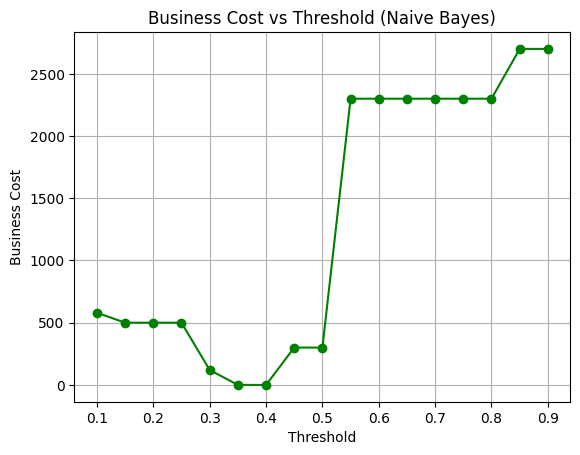


✅ OPTIMAL THRESHOLD (NB)
Threshold          0.35
Precision          1.00
Recall             1.00
F1 Score           1.00
False Positives    0.00
False Negatives    0.00
Business Cost      0.00
Name: 5, dtype: float64


In [7]:
import joblib, random, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, UTC
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

ARTIFACT_DIR = r"C:\medveraxbecustom\model_artifacts"
MODEL_PATH = f"{ARTIFACT_DIR}\\naive_bayes_model.pkl"
VECTORIZER_PATH = f"{ARTIFACT_DIR}\\tfidf_vectorizer.pkl"

model = joblib.load(MODEL_PATH)
vectorizer = joblib.load(VECTORIZER_PATH)

print("✅ Naive Bayes model loaded")

random.seed(42)
diseases = ["diabetes","cancer","hypertension","asthma","arthritis","covid"]

reliable = [
    "Medical professionals manage {d}",
    "Treatment depends on diagnosis for {d}"
]
misinfo = [
    "Home remedies cure {d} permanently",
    "{d} does not require medical treatment"
]

texts, labels = [], []
for _ in range(50):
    texts.append(random.choice(reliable).format(d=random.choice(diseases)))
    labels.append(0)
for _ in range(50):
    texts.append(random.choice(misinfo).format(d=random.choice(diseases)))
    labels.append(1)

X = vectorizer.transform(texts)
y = np.array(labels)
probs = model.predict_proba(X)[:,1]

thresholds = np.arange(0.1, 0.91, 0.05)
rows = []

for t in thresholds:
    preds = (probs >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y, preds).ravel()
    cost = fn*100 + fp*20
    rows.append({
        "Threshold": t,
        "Precision": precision_score(y, preds),
        "Recall": recall_score(y, preds),
        "F1 Score": f1_score(y, preds),
        "False Positives": fp,
        "False Negatives": fn,
        "Business Cost": cost
    })

df_nb = pd.DataFrame(rows)

print("\n📊 NAIVE BAYES THRESHOLD TABLE")
print(df_nb.round(3))

plt.plot(df_nb["Threshold"], df_nb["Business Cost"], marker="o", color="green")
plt.title("Business Cost vs Threshold (Naive Bayes)")
plt.xlabel("Threshold")
plt.ylabel("Business Cost")
plt.grid(True)
plt.show()

best = df_nb.loc[df_nb["Business Cost"].idxmin()]
print("\n✅ OPTIMAL THRESHOLD (NB)")
print(best)


threshold tuning random forest

✅ Random Forest model loaded

📊 RANDOM FOREST THRESHOLD TABLE
    Threshold  Precision  Recall  F1 Score  False Positives  False Negatives  \
0        0.10      0.500    1.00     0.667               50                0   
1        0.15      0.500    1.00     0.667               50                0   
2        0.20      0.500    1.00     0.667               50                0   
3        0.25      0.500    1.00     0.667               50                0   
4        0.30      0.667    1.00     0.800               25                0   
5        0.35      0.653    0.94     0.770               25                3   
6        0.40      0.653    0.94     0.770               25                3   
7        0.45      0.519    0.54     0.529               25               23   
8        0.50      0.548    0.46     0.500               19               27   
9        0.55      0.548    0.46     0.500               19               27   
10       0.60      0.548    0.46     0.500               1

C:\Users\bhanu\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\bhanu\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\bhanu\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape

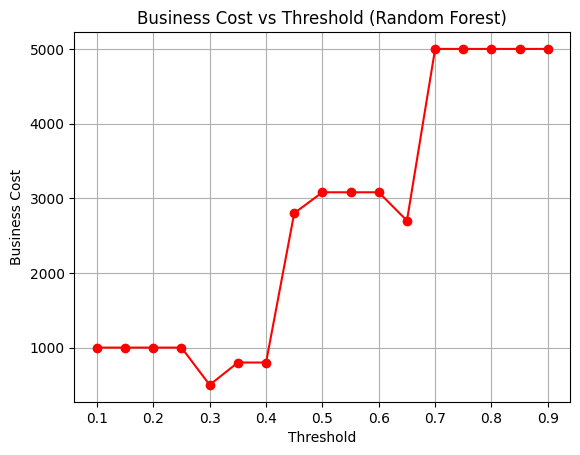


✅ OPTIMAL THRESHOLD (RF)
Threshold            0.300000
Precision            0.666667
Recall               1.000000
F1 Score             0.800000
False Positives     25.000000
False Negatives      0.000000
Business Cost      500.000000
Name: 4, dtype: float64


In [8]:
import joblib, random, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, UTC
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

ARTIFACT_DIR = r"C:\medveraxbecustom\model_artifacts"
MODEL_PATH = f"{ARTIFACT_DIR}\\random_forest_model.pkl"
VECTORIZER_PATH = f"{ARTIFACT_DIR}\\tfidf_vectorizer.pkl"

model = joblib.load(MODEL_PATH)
vectorizer = joblib.load(VECTORIZER_PATH)

print("✅ Random Forest model loaded")

random.seed(42)
diseases = ["diabetes","cancer","hypertension","asthma","arthritis","covid"]

reliable = [
    "Clinical treatment is advised for {d}",
    "Doctors manage {d} using proven therapies"
]
misinfo = [
    "{d} is curable naturally without doctors",
    "Miracle cure exists for {d}"
]

texts, labels = [], []
for _ in range(50):
    texts.append(random.choice(reliable).format(d=random.choice(diseases)))
    labels.append(0)
for _ in range(50):
    texts.append(random.choice(misinfo).format(d=random.choice(diseases)))
    labels.append(1)

X = vectorizer.transform(texts)
y = np.array(labels)
probs = model.predict_proba(X)[:,1]

thresholds = np.arange(0.1, 0.91, 0.05)
rows = []

for t in thresholds:
    preds = (probs >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y, preds).ravel()
    cost = fn*100 + fp*20
    rows.append({
        "Threshold": t,
        "Precision": precision_score(y, preds),
        "Recall": recall_score(y, preds),
        "F1 Score": f1_score(y, preds),
        "False Positives": fp,
        "False Negatives": fn,
        "Business Cost": cost
    })

df_rf = pd.DataFrame(rows)

print("\n📊 RANDOM FOREST THRESHOLD TABLE")
print(df_rf.round(3))

plt.plot(df_rf["Threshold"], df_rf["Business Cost"], marker="o", color="red")
plt.title("Business Cost vs Threshold (Random Forest)")
plt.xlabel("Threshold")
plt.ylabel("Business Cost")
plt.grid(True)
plt.show()

best = df_rf.loc[df_rf["Business Cost"].idxmin()]
print("\n✅ OPTIMAL THRESHOLD (RF)")
print(best)
